# Tutorial on how to load the EXBA mask data and create aperture mask using the PRF models

In [1]:
import os, sys, glob
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import lightkurve as lk
path = os.path.dirname(os.getcwd())

sys.path.append(path)
import src.kepler_apertures as ka

# Load EXBA masks data

First we create and EXBAMachine object that will load the EXBA mask images (download them if not local), tile them to create the full EXBA mask, and query Gaia catalog to obtain the observed sources.
To initialize this object, we have to give the quarter and channel numbers. Optionally we can use Gaia DR2 or EDR3 and define the limiting magnitude for the search. Gaia queries are stored locally for further use.

In [2]:
q = 16
ch = 52
exba = ka.EXBAMachine(quarter=q, channel=ch, magnitude_limit=20, gaia_dr=3)

TargetPixelFileCollection of 4 objects:
    0: KeplerTargetPixelFile Object (ID: 100003277)
    1: KeplerTargetPixelFile Object (ID: 100003278)
    2: KeplerTargetPixelFile Object (ID: 100003279)
    3: KeplerTargetPixelFile Object (ID: 100003280)
Loading query from file...
/Users/jorgemarpa/Work/BAERI/ADAP/kepler-apertures/data/catalogs/exba/16/channel_52_gaiadr3_xmatch.csv


We can conveniently plot the full EXBA image

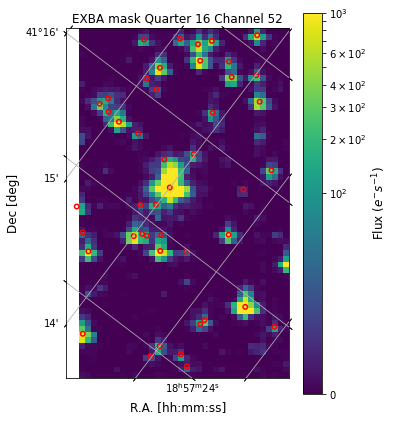

In [6]:
ax = exba.plot_image()
plt.show()

And we can access the source catalog from `exba.sources` for reference

In [7]:
exba.sources.head(10)

,designation,ra,ra_error,dec,dec_error,pmra,pmdec,parallax,parallax_error,phot_g_n_obs,...,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_mag,col,row,clean_flag
0,Gaia EDR3 2104466045839475200,283.254803,0.074179,41.329875,0.084304,-2.213980,-4.237774,0.285859,0.086694,363,...,696.530420,9.086688,18.231192,36,900.955306,7.549617,17.361137,588.451835,593.145945,0
1,Gaia EDR3 2104466050136199296,283.246627,0.308799,41.331828,0.373801,-2.812662,-1.663655,1.120881,0.368950,306,...,91.519695,6.149502,20.434755,30,123.043786,7.007735,19.522747,583.637138,589.858059,0
2,Gaia EDR3 2104466118855670400,283.224213,0.164977,41.311188,0.196079,-0.248123,-4.596106,0.127625,0.208389,368,...,156.061404,7.296156,19.855303,34,341.644918,6.775155,18.413958,588.964429,566.355003,0
3,Gaia EDR3 2104466183278417664,283.202689,0.291753,41.319600,0.346007,-1.472798,-4.234395,1.183006,0.362463,374,...,71.712137,6.625856,20.699560,37,191.897334,6.971627,19.040224,573.952452,559.527256,0
4,Gaia EDR3 2104466183278419968,283.204154,0.158391,41.321935,0.184185,-1.978530,-6.792018,0.352634,0.195431,369,...,153.058164,8.363887,19.876402,41,366.303671,10.162640,18.338293,572.902267,561.613662,0
5,Gaia EDR3 2104466183278425216,283.202509,0.094262,41.326040,0.107543,0.383215,-6.225819,0.538545,0.113864,349,...,364.259225,8.834456,18.935017,40,728.831549,7.395265,17.591328,569.287858,563.022578,0
6,Gaia EDR3 2104466183279458944,283.213199,0.232196,41.322533,0.260214,-3.170348,-9.066558,0.228847,0.281975,382,...,115.255260,7.414924,20.184391,36,167.735881,6.232076,19.186330,576.264937,566.786743,0
7,Gaia EDR3 2104466187575144960,283.199028,0.248898,41.326219,0.296923,-0.622328,-3.806268,-0.006056,0.317023,355,...,115.302190,6.520993,20.183949,35,140.446919,5.866769,19.379114,567.702167,561.260173,0
8,Gaia EDR3 2104466187575147904,283.214630,0.082265,41.322394,0.092217,-3.974716,-8.979254,0.226449,0.097790,408,...,486.170076,8.156793,18.621572,44,651.884177,9.518785,17.712470,576.963432,567.474801,0
9,Gaia EDR3 2104466217638172160,283.225347,0.225001,41.333171,0.236939,-6.087003,-0.679160,0.525293,0.275008,339,...,78.720855,6.437147,20.598318,30,311.956191,8.081710,18.512661,573.770629,579.218747,0


## Load PRF model

Now we use `KeplerPRF` class to load corresponding PRF model

In [8]:
kprf = ka.KeplerPRF.load_from_file(quarter=q, channel=ch)

We now evaluate the PRF model in the pixel dx and dy grid from the EXBA image. This will return a sparse matrix with the PRF evaluated in all sources, aka a normalized model of the EXBA image with each row containing only one source.

In [9]:
psf_exba = kprf.evaluate_PSF(exba.dx, exba.dy)
psf_exba

<45x2160 sparse matrix of type '<class 'numpy.float64'>'
	with 1203 stored elements in Compressed Sparse Row format>

### Create Photometric apertures

The photometric aperture can be find by giving the percentile that controls the aperture size to `kprf.create_aperture_mask()` or by optimizing the flux metrics with `kprf.optimize_aperture`. Both functions input the output of `kprf.evaluate_PSF` and the index of the source we want to obtain the aperture.

In [10]:
for s in range(exba.sources.shape[0]):
    # find the optimized aperture
    ap_mask, crwd, cmplt, cut = kprf.optimize_aperture(psf_exba, idx=s, target_complet=0.1, target_crowd=1.)

    # or give the percentile and get the corresponding aperture
    # ap_mask, crwd, cmplt = kprf.create_aperture_mask(psf_exba, idx=s, percentile=90)
    
    # we update the aperture mask and flux metrics attributes of the exba object
    # this will be used during plotting and LC construction as metadata.
    exba.aperture_mask[s] = ap_mask
    exba.FLFRCSAP[s] = crwd
    exba.CROWDSAP[s] = cmplt
    exba.cut[s] = cut
exba.aperture_mask_2d = exba.aperture_mask.reshape(exba.n_sources, exba.n_rows, exba.n_columns)

Now we inspect the apertures we created, and the flux metrics as a function of the parameter that controls the aperture size

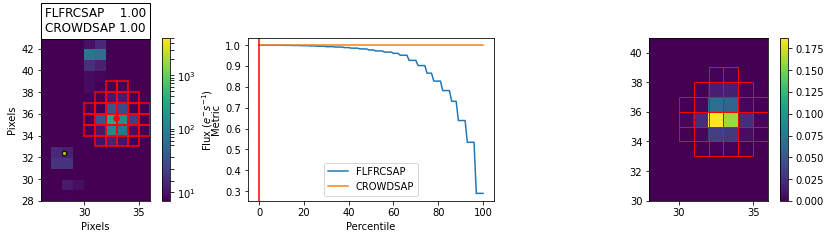

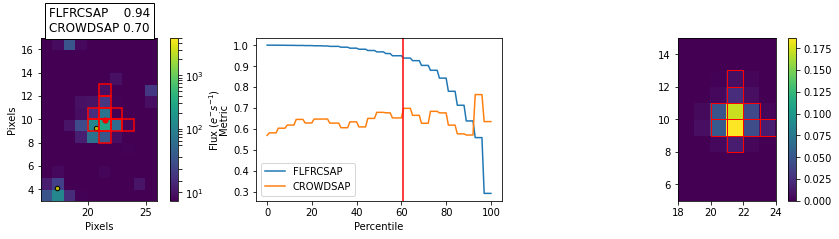

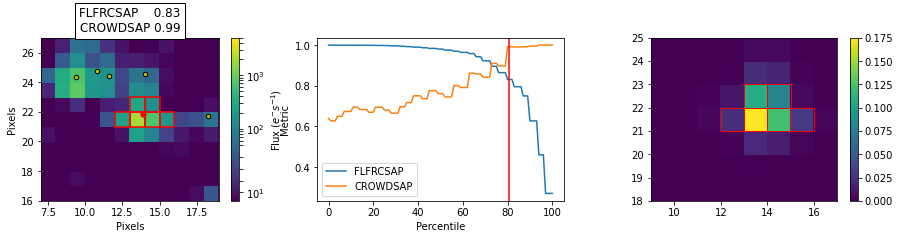

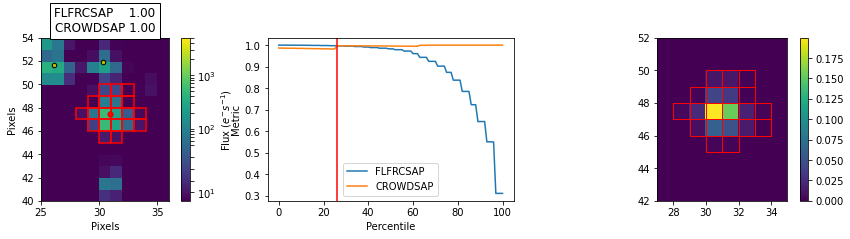

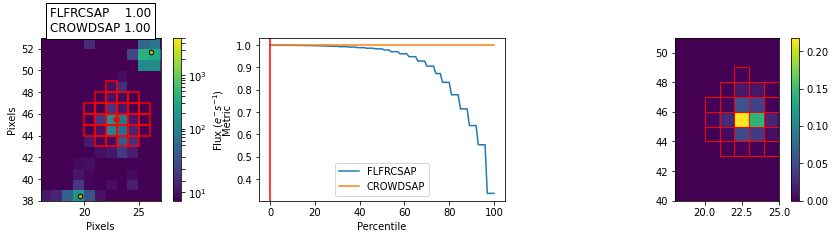

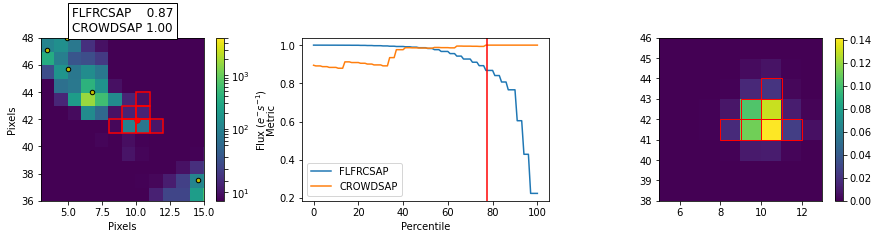

In [11]:
for s in range(0, exba.sources.shape[0], 8):
    fig, ax = plt.subplots(1,3, figsize=(15,3))
    ax[0] = exba.plot_stamp(source_idx=s, aperture_mask=True, ax=ax[0])
    ax[1] = kprf.diagnose_metrics(psf_exba, idx=s, ax=ax[1])
    ax[1].axvline(exba.cut[s], ls='-', c='r')
    ax[2] = kprf.plot_aperture(psf_exba[s].toarray().reshape(exba.flux_2d.shape[1:]), 
                               mask=exba.aperture_mask_2d[s], ax=ax[2], log=False)
    plt.show()
    # break

### Create LCs

With `exba.create_lcs` we create a new object attribute `exba.lcs` that contains all the new light curves as a `lightkurve.LightCurveCollection`

In [12]:
exba.create_lcs(exba.aperture_mask)

SAP:   0%|          | 0/45 [00:00<?, ?it/s]

Using the convenient functions that plot the light curve and image stamp of sources (s=10) we can inspect the results

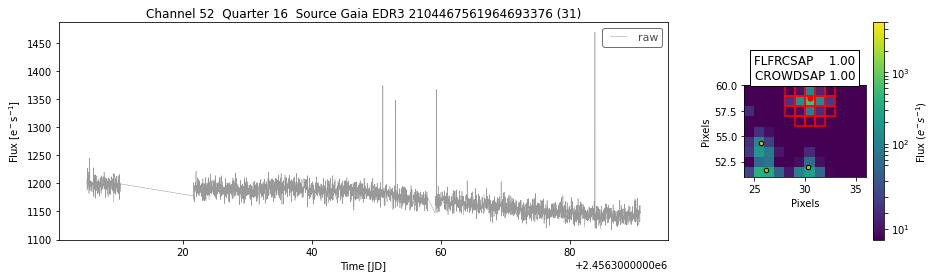

In [13]:
s = 31

fig, ax = plt.subplots(
    1, 2, figsize=(15, 4), gridspec_kw={"width_ratios": [4, 1]}
)
exba.plot_lightcurve(source_idx=s, ax=ax[0])
exba.plot_stamp(source_idx=s, ax=ax[1], aperture_mask=True)

plt.show()